# 本小节核心是介绍AI模型是如何处理字符数据的

## 字符编码和解码

In [ ]:
#加载字典和分词器
from transformers import BertTokenizer
token=BertTokenizer.from_pretrained(r"D:\PyCharm\day02_SentimentEvaluationBasedOnBert\model\bert-base-chinese\models--bert-base-chinese\snapshots\c30a6ed22ab4564dc1e3b2ecbf6e766b0611a33f")
#print(token)

#准备要编码的文本数据
sents = ["白日依山尽，",
         "价格在这个地段属于适中, 附近有早餐店,小饭店, 比较方便,无早也无所"]
#批量编码句子
out=token.batch_encode_plus(
    batch_text_or_text_pairs=[sents[0],sents[1]],#传入句子
    add_special_tokens=True,#是否添加特殊字符
    truncation=True,#是否截断，当句子长度大于max_length是就截断
    max_length=8,#max_length的上限是512，
    padding="max_length",#如果没达到则一律补0到max_length
    return_tensors=None,#编码后返回数值的类型，可取值为tf,pt,np,给None默认为list
    return_attention_mask=True,
    return_token_type_ids=True,
    return_speaker_ids=True,
    return_length=True#返回序列长度
)

for k,v in out.items():
    print(k,":",v)

#解码文本数据
print(token.decode(out["input_ids"][0]),token.decode(out["input_ids"][1]))


## 数据获取

### 访问Hugging Face

开启科学上网，访问Hugging Face
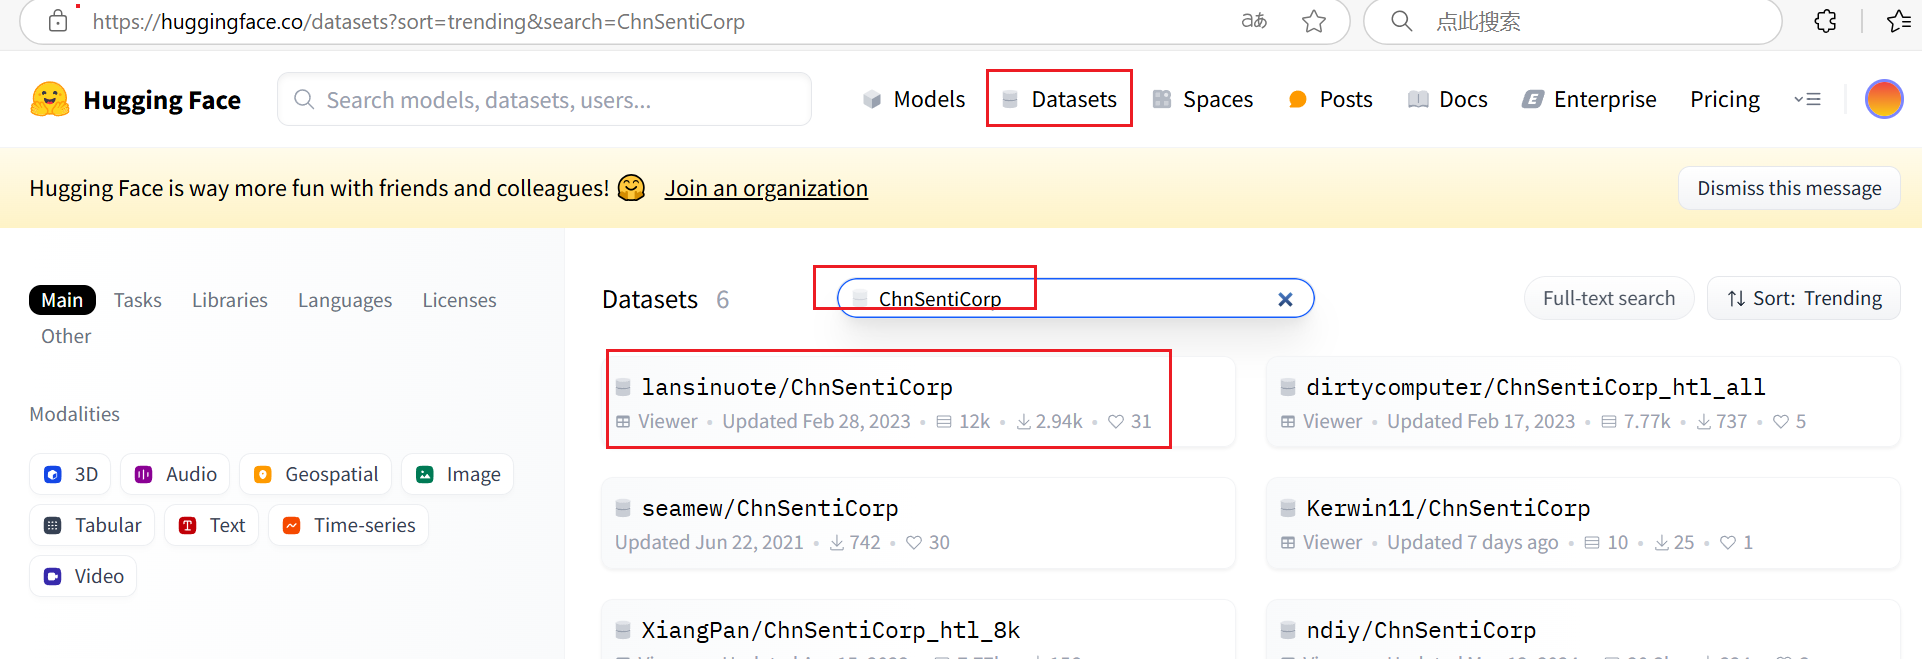

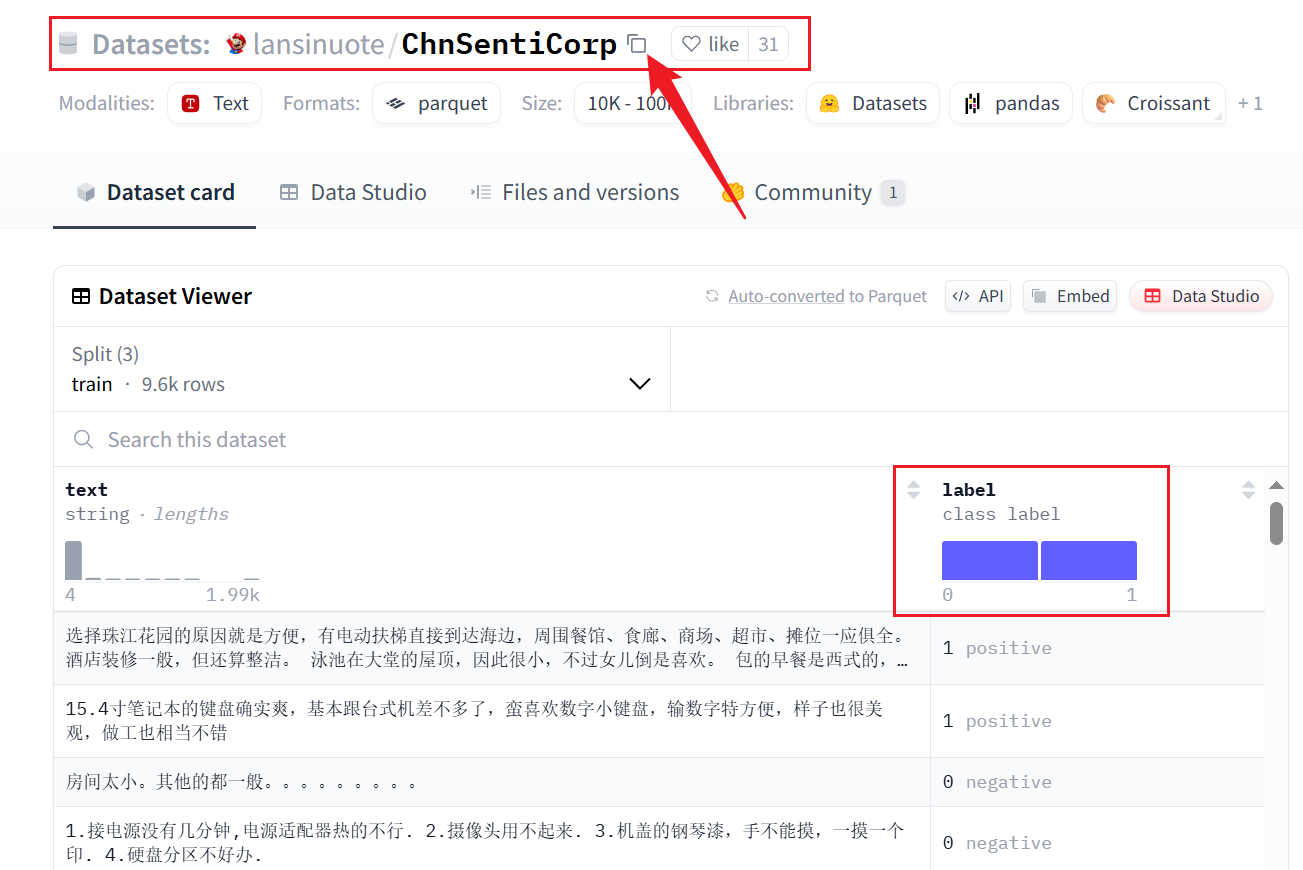

### 从huggingface下载

In [ ]:

from datasets import load_dataset,load_from_disk

#在线加载数据集,加载的是中文情感分析数据集,包含两个类别，正面和负面,注意开启科学上网
#如果不设置目录则默认保存在本地的C:\Users\admin\.cache\huggingface\datasets
#dataset = load_dataset(path="lansinuote/ChnSentiCorp")
dataset = load_dataset(path="lansinuote/ChnSentiCorp",cache_dir="data/")
print(dataset)


### 加载下载好的数据

In [ ]:

#加载缓存数据集，用到load_from_disk这个包,要给绝对路径，路径给到dataset_info.json文件的所在目录
#如果加载错误，可能是路径不对，或者路径下没有dataset_info.json文件，或者换一个数据集试试
dataset = load_from_disk(r"D:\PyCharm\day02_SentimentEvaluationBasedOnBert\data\ChnSentiCorp")
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9600
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1200
    })
})
在输出中，分为训练、验证、和测试三个部分

### 查看数据集

In [ ]:
train_dataset = dataset["train"]
for data in train_dataset:
    print(data)

### 拓展：加载csv数据

In [ ]:
dataset=load_dataset(path="csv",data_files=r"D:\PyCharm\day02_SentimentEvaluationBasedOnBert\data\hermes-function-calling-v1.csv")
print(dataset)

## 制作数据集（转换数据格式）

In [ ]:
from torch.utils.data import Dataset
from datasets import load_from_disk
#新建一个类，继承pytorch的Dataset类,重写__init__,__len__,__getitem__方法
class MyDataset(Dataset):
    def __init__(self,split):#初始化数据集
        #从磁盘加载数据集
        self.dataset=load_from_disk(r"data\ChnSentiCorp")
        if "train"==split:
            self.dataset=self.dataset["train"]
        elif "test"==split:
            self.dataset=self.dataset["test"]
        elif "validation"==split:
            self.dataset=self.dataset["validation"]
        else:
            print("split参数错误")

    def __len__(self):#返回数据集的长度
        return len(self.dataset)
    
    def __getitem__(self, idx):#返回数据集的第idx个数据，对每条数据进行单独处理
        text=self.dataset[idx]["text"]
        label=self.dataset[idx]["label"]
        return text,label

#测试
if __name__=="__main__":
    dataset=MyDataset("test")
    for data in dataset:
        print(data)


## 模型设计

In [ ]:
import torch
from transformers import BertModel

#定义设备信息
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

#加载预训练模型,注意结尾的to(DEVICE)是将模型加载到设备上，是cpu还是gpu取决于DEVICE
pretrained=BertModel.from_pretrained(r"D:\PyCharm\day02_SentimentEvaluationBasedOnBert\model\bert-base-chinese\models--bert-base-chinese\snapshots\c30a6ed22ab4564dc1e3b2ecbf6e766b0611a33f").to(DEVICE)
print(pretrained)

#定义下游任务模型（增量模型）
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #设计全连接网络，实现二分类任务
        self.fc=torch.nn.Linear(in_features=768,out_features=2)
 
#使用模型处理数据（执行前向计算）
def forward(self,input_ids,attention_mask,token_type_ids):
    #冻结Bert模型的参数,让其不参与训练
    with torch.no_grad():
        #获取Bert模型的输出
        output=pretrained(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)

    #增量模型参与训练
    output=self.fc(output.last_hidden_state[:,0])#取出最后的序列特征，最后一段序列特征包含完整的句子信息
    return output











## 模型训练

In [ ]:
#导入模型用
import torch

from 制作数据集 import MyDataset
#用于加载数据集
from torch.utils.data import DataLoader
#用于加载刚刚设计的模型
from 模型设计 import Model
#用于加载预训练模型,BertTokenizer是用于加载字典和分词器，AdamW是用于加载优化器
from transformers import BertTokenizer,AdamW

#定义设备信息
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

#定义训练的轮次（将整个数据集训练完一次为一个轮次）
EPOCH=30000
#加载字典和分词器
token=BertTokenizer.from_pretrained(r"D:\PyCharm\day02_SentimentEvaluationBasedOnBert\model\bert-base-chinese\models--bert-base-chinese\snapshots\c30a6ed22ab4564dc1e3b2ecbf6e766b0611a33f")

#将传进来的字符串数据进行编码
def collate_fn(data):
    sents=[i[0] for i in data]
    labels=[i[1] for i in data]
    #批量编码句子
    data=token.batch_encode_plus(
        batch_text_or_text_pairs=sents,#传入句子
        truncation=True,#是否截断，当句子长度大于max_length是就截断
        max_length=512,#max_length的上限是512，
        padding="max_length",#如果没达到则一律补0到max_length
        return_tensors="pt",#编码后返回数值的类型，可取值为tf,pt,np,给None默认为list
        return_length=True#返回序列长度
    )

    input_ids=data["input_ids"]
    attention_mask=data["attention_mask"]
    token_type_ids=data["token_type_ids"]
    labels=torch.LongTensor(labels)
    return input_ids,attention_mask,token_type_ids,labels

#创建数据集
train_dataset=MyDataset("train")
#取数据
train_loader=DataLoader(
    dataset=train_dataset,
    batch_size=500,#每次取几条数据，超参数，让GPU能显存占用90%左右，如果cpu怎内存占用90%左右
    shuffle=True,#是否打乱数据
    drop_last=True,#是否丢弃最后一个不足batch_size的batch
    collate_fn=collate_fn#是否自定义数据集的处理方式
    )


if __name__=="__main__":
    #开始训练
    print(DEVICE)
    model=Model().to(DEVICE)
    #定义优化器
    optimizer=AdamW(model.parameters())
    #定义损失函数
    loss_func=torch.nn.CrossEntropyLoss()

    for epoch in range(EPOCH):
        for i,(input_ids,attention_mask,token_type_ids,labels) in enumerate(train_loader):
            #将数据加载到设备上
            input_ids=input_ids.to(DEVICE)
            attention_mask=attention_mask.to(DEVICE)
            token_type_ids=token_type_ids.to(DEVICE)
            labels=labels.to(DEVICE)

            #前向计算(将数据输入模型，得到输出)
            output=model(input_ids,attention_mask,token_type_ids)
            #计算损失
            loss=loss_func(output,labels)
            #梯度清零
            optimizer.zero_grad()
            #反向传播
            loss.backward()
            #更新参数
            optimizer.step()
            print(loss.item())

            #每隔5个批次输出训练信息
            if 0==i%5:
                out=out.argmax(dim=1)
                #计算训练精度
                acc=(out==labels).sum().item()/len(labels)
                print(f"epoch:{epoch},i:{i},loss:{loss.item()},acc:{acc}")

        #保存模型
        torch.save(model.state_dict(),f"params/{epoch}_bert.pth")
        print("模型已保存成功！")




ModuleNotFoundError: No module named '制作数据集'